In [1]:
import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation
import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn.functional as F # import convolution functions like Relu
import clip
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns


In [2]:
# CIFAR Dataset

transform = transforms.Compose( # composing several transforms together
    [transforms.ToTensor(), # to tensor object
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ]) # mean = 0.5, std = 0.5

# set batch_size
batch_size = 1

# set number of workers
num_workers = 1

# load train data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

# load test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

# put 10 classes into a set
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
t2im = transforms.ToPILImage()
im2t = transforms.PILToTensor()
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

torch.Size([1, 3, 32, 32]) car


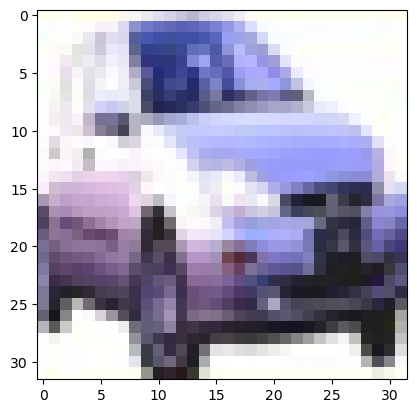

In [4]:
# CIFAR Sample Img
for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    plt.imshow(t2im(inputs.squeeze()))
    print(inputs.shape, classes[labels])
    break

torch.Size([1, 3, 224, 224])
Label probs: [[0.9970771  0.00292291]]


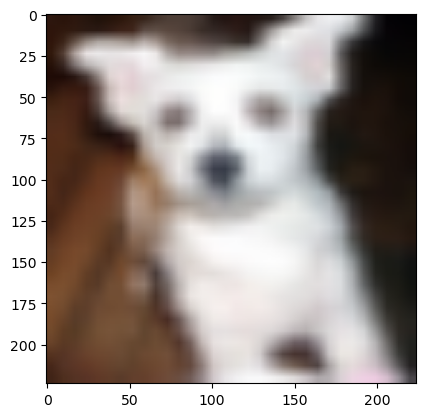

In [5]:
# Upsampling
with torch.no_grad():
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = torch.nn.functional.interpolate(inputs, scale_factor=7, mode='bilinear', align_corners=False)
        plt.imshow(t2im(inputs.squeeze()))
        text = clip.tokenize(["A picture of a " + classes[labels], "other"]).to(device)
        print(inputs.shape)
        image_features = model.encode_image(inputs)
        text_features = model.encode_text(text)
        logits_per_image, logits_per_text = model(inputs, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        print("Label probs:", probs) 
        break

In [6]:
# Compute embeddings for each sample
embeddings = []
truths = []
with torch.no_grad():
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = torch.nn.functional.interpolate(inputs, scale_factor=7, mode='bilinear', align_corners=False)
        #text = clip.tokenize(["A picture of a " + classes[labels], "other"]).to(device)
        image_features = model.encode_image(inputs)
        #text_features = model.encode_text(text)
        #logits_per_image, logits_per_text = model(inputs, text)
        #probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        embeddings.append(image_features.reshape(-1,1).squeeze().detach().cpu().numpy())
        truths.append(classes[labels])
print(len(embeddings), embeddings[0].shape, len(truths))

50000 (512,) 50000


In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.asarray(embeddings), truths, test_size=0.2, random_state=18)

# Initialize the LDA model
lda = LinearDiscriminantAnalysis()

# Fit the LDA model on the training data
lda.fit(X_train, y_train)

# Transform the data using the LDA model
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

In [9]:
# Train a classifier on the transformed data (you can use any classifier of your choice)
# Here, we'll use a simple logistic regression classifier
classifier = LogisticRegression()
classifier.fit(X_train_lda, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test_lda)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8582


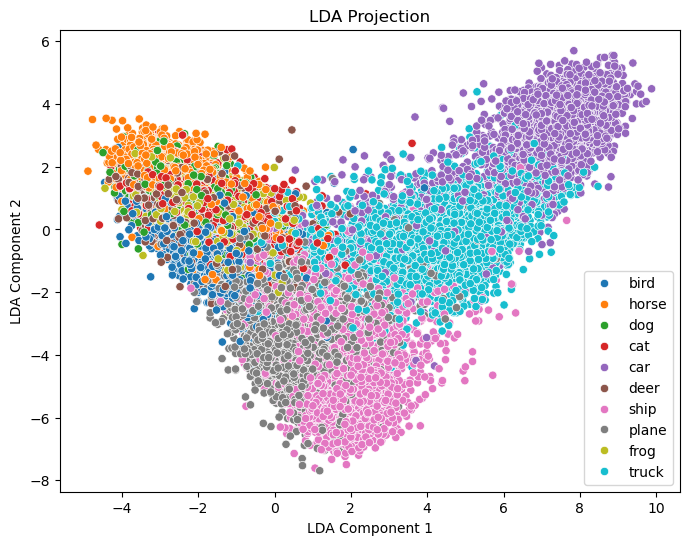

In [21]:
# Assuming X_lda is the transformed data and y is the class labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_lda[:, 0], y=X_train_lda[:, 1], hue=y_train, palette='tab10')
plt.title('LDA Projection')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.show()

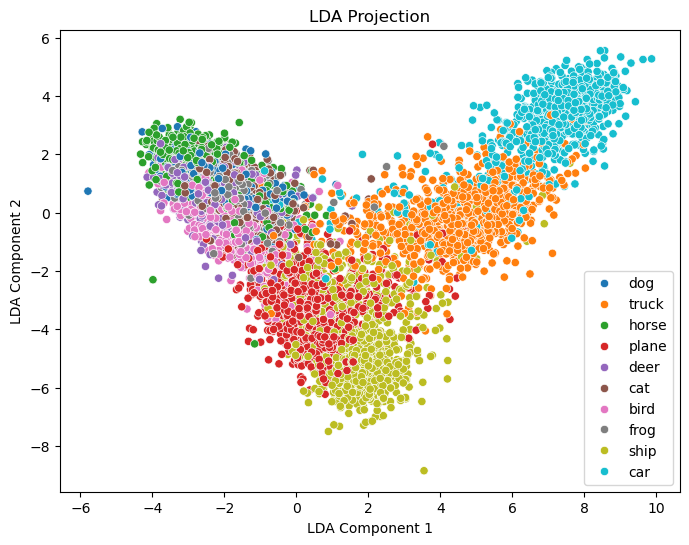

In [20]:
# Assuming X_lda is the transformed data and y is the class labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test_lda[:, 0], y=X_test_lda[:, 1], hue=y_test, palette='tab10')
plt.title('LDA Projection')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.show()

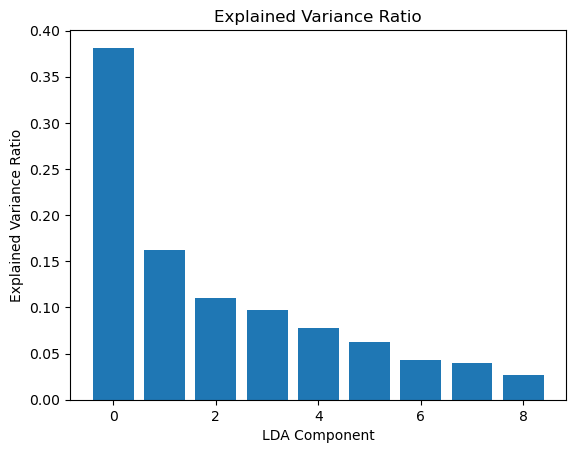

In [14]:
plt.bar(range(len(lda.explained_variance_ratio_)), lda.explained_variance_ratio_)
plt.title('Explained Variance Ratio')
plt.xlabel('LDA Component')
plt.ylabel('Explained Variance Ratio')
plt.show()